<h1 id="tocheading">Attrition Demo</h1>
<div id="toc"></div>

<img src="https://github.com/elenalowery/DSX_Local_Workshop/blob/master/img/CC_Intro.JPG?raw=true" width="800" height="500" align="middle"/>

The Attrition demo focuses on retaining Merchants that are using company network for credit card processing. Here is the description of the case:

A client approved many low value merchant accounts without much scrutiny.  Many of those merchant accounts resulted in default. The client thinks that they should have put more of an emphasis on their applicant screening process. IBM suggests to enable fact based decision making for performance of its joint marketing programs.

This notebook will demostrate how to

1. Use Brunel and Seaborn library for visualizations

2. Use regular python Machine Learning libary scikit-learn and Spark's Machine Learning library(MLlib) for predicitive modeling in an intergrated environment on DSX.
3. Deploy SparkML model using Machine Learning Service

## Set up environment

In [1]:
import sklearn

import pandas as pd
pd.options.display.max_columns = 999

import brunel

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency,ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score

import numpy as np

import urllib3, requests, json

## Load Customer History Data

In [3]:
cust_pd = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/CUST_HISTORY.csv')
cust_pd.head()

MERCHANT ACCT_STATUS_K_USD  CONTRACT_DURATION_MONTH  \
0       893             0 USD                       12   
1       894      0 to 200 USD                       36   
2       895              NONE                       18   
3       896              NONE                       36   
4       897             0 USD                       21   

                      HISTORY CREDIT_PROGRAM  AMOUNT_K_USD     ACCOUNT_TYPE  \
0            CRITICAL ACCOUNT        NEW CAR          2171  up to 100 K USD   
1            CRITICAL ACCOUNT       USED CAR          5800  up to 100 K USD   
2            CRITICAL ACCOUNT    ELECTRONICS          1169     UNKNOWN/NONE   
3               DELAY IN PAST       USED CAR          8947     UNKNOWN/NONE   
4  EXISTING CREDITS PAID BACK    ELECTRONICS          2606  up to 100 K USD   

     ACCT_AGE STATE IS_URBAN IS_XBORDER SELF_REPORTED_ASMT CO_APPLICANT  \
0  1 to 4 YRS    NY       NO        YES                 NO           NO   
1  1 to 4 YRS    CT       NO        YES                 NO           NO   
2  1 to 4 YRS    NY       NO        YES                 NO           NO   
3  4 to 7 YRS    CT       NO        YES                 NO           NO   
4  up to 1 YR    NY       NO         NO                 NO           NO   

  GUARANTOR PRESENT_RESIDENT OWN_REAL_ESTATE PROP_UNKN  ESTABLISHED_MONTH  \
0        NO                4              NO        NO                 38   
1        NO                4              NO        NO                 34   
2        NO      above 4 YRS              NO        NO                 29   
3        NO       2 to 3 YRS              NO        NO                 31   
4        NO                4              NO        NO                 28   

  OTHER_INSTALL_PLAN RENT OWN_RESIDENCE  NUMBER_CREDITS  RFM_SCORE  BRANCHES  \
0                YES   NO           YES               2          2         1   
1                 NO   NO           YES               2          3         1   
2                 NO   NO           YES               2          3         1   
3                YES   NO           YES               1          4         2   
4                 NO  YES            NO               1          4         1   

  TELEPHONE SHIP_INTERNATIONAL IS_DEFAULT  
0        NO                YES         No  
1       YES                 NO         No  
2       YES                 NO         No  
3       YES                 NO         No  
4       YES                 NO         No

### Dataset Overview

Let's take a quick look at the dataset.

In [4]:
print "There are " + str(len(cust_pd)) + " observations in the customer history dataset."
print "There are " + str(len(cust_pd.columns)) + " variables in the dataset."

print "\n******************Descriptive statistics*****************************\n"
print cust_pd.describe()

print "\n******************Dataset Quick View*****************************\n"
cust_pd.head()

There are 1000 observations in the customer history dataset.
There are 27 variables in the dataset.

******************Descriptive statistics*****************************

          MERCHANT  CONTRACT_DURATION_MONTH  AMOUNT_K_USD  ESTABLISHED_MONTH  \
count  1000.000000              1000.000000   1000.000000        1000.000000   
mean    500.500000                20.903000   3271.258000          35.546000   
std     288.819436                12.058814   2822.736876          11.375469   
min       1.000000                 4.000000    250.000000          19.000000   
25%     250.750000                12.000000   1365.500000          27.000000   
50%     500.500000                18.000000   2319.500000          33.000000   
75%     750.250000                24.000000   3972.250000          42.000000   
max    1000.000000                72.000000  18424.000000          75.000000   

       NUMBER_CREDITS    RFM_SCORE     BRANCHES  
count     1000.000000  1000.000000  1000.000000  
mean   

MERCHANT ACCT_STATUS_K_USD  CONTRACT_DURATION_MONTH  \
0       893             0 USD                       12   
1       894      0 to 200 USD                       36   
2       895              NONE                       18   
3       896              NONE                       36   
4       897             0 USD                       21   

                      HISTORY CREDIT_PROGRAM  AMOUNT_K_USD     ACCOUNT_TYPE  \
0            CRITICAL ACCOUNT        NEW CAR          2171  up to 100 K USD   
1            CRITICAL ACCOUNT       USED CAR          5800  up to 100 K USD   
2            CRITICAL ACCOUNT    ELECTRONICS          1169     UNKNOWN/NONE   
3               DELAY IN PAST       USED CAR          8947     UNKNOWN/NONE   
4  EXISTING CREDITS PAID BACK    ELECTRONICS          2606  up to 100 K USD   

     ACCT_AGE STATE IS_URBAN IS_XBORDER SELF_REPORTED_ASMT CO_APPLICANT  \
0  1 to 4 YRS    NY       NO        YES                 NO           NO   
1  1 to 4 YRS    CT       NO        YES                 NO           NO   
2  1 to 4 YRS    NY       NO        YES                 NO           NO   
3  4 to 7 YRS    CT       NO        YES                 NO           NO   
4  up to 1 YR    NY       NO         NO                 NO           NO   

  GUARANTOR PRESENT_RESIDENT OWN_REAL_ESTATE PROP_UNKN  ESTABLISHED_MONTH  \
0        NO                4              NO        NO                 38   
1        NO                4              NO        NO                 34   
2        NO      above 4 YRS              NO        NO                 29   
3        NO       2 to 3 YRS              NO        NO                 31   
4        NO                4              NO        NO                 28   

  OTHER_INSTALL_PLAN RENT OWN_RESIDENCE  NUMBER_CREDITS  RFM_SCORE  BRANCHES  \
0                YES   NO           YES               2          2         1   
1                 NO   NO           YES               2          3         1   
2                 NO   NO           YES               2          3         1   
3                YES   NO           YES               1          4         2   
4                 NO  YES            NO               1          4         1   

  TELEPHONE SHIP_INTERNATIONAL IS_DEFAULT  
0        NO                YES         No  
1       YES                 NO         No  
2       YES                 NO         No  
3       YES                 NO         No  
4       YES                 NO         No

## Exploratory Data Analysis

In this section, we will explore the dataset further with some visualizations.

Two open source libraries are used:
* <a href="https://github.com/Brunel-Visualization/Brunel">Brunel</a> is a high-level language that describes visualizations in terms of composable actions. It drives a visualization engine (D3) that performs the actual rendering and interactivity. Brunel makes it much easier to build fun and inventive visualizations in Jupyter notebooks.

* <a href="https://seaborn.pydata.org/">Seaborn</a> is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics.

### Outcome Variable: Account Default

In [5]:
%brunel data('cust_pd') x(IS_DEFAULT) y(#count) color(IS_DEFAULT) bar tooltip(#all)

<IPython.core.display.Javascript object>

As you can see from the bar chart, 300 out of 1000 accounts are in default.

### Default by Credit Program

In [6]:
%brunel data('cust_pd') polar stack bar y(#count) color(CREDIT_PROGRAM) percent(#count) tooltip(#all) | stack bar x(CREDIT_PROGRAM) y(#count) color(IS_DEFAULT) bin(CREDIT_PROGRAM) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

* Top 3 credit programs with most Merchants are Electronics(28%), New Car(23.4%) and Furniture(18.1%).
* Top 3 credit programs with high default rate are Education(44%), New Car(38%), and Retraining(35.1%)

### HISTORY vs. IS_DEFAULT

In [7]:
%brunel data('cust_pd') bar x(HISTORY) y(#count) color(HISTORY) tooltip(#all) | stack bar x(HISTORY) y(#count) color(IS_DEFAULT: green-red) bin(HISTORY) sort(HISTORY) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

### AMOUNT_K_USD vs. IS_DEFAULT

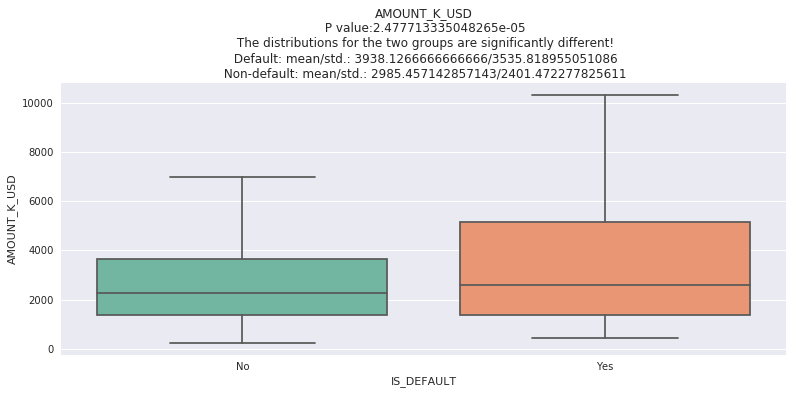

In [8]:
sub_yes = cust_pd[cust_pd["IS_DEFAULT"] == "Yes"]
sub_no = cust_pd[cust_pd["IS_DEFAULT"] == "No"]
    
p_value = ttest_ind(sub_yes['AMOUNT_K_USD'], sub_no["AMOUNT_K_USD"], equal_var = False)[1]

fig, axs = plt.subplots(nrows= 1, figsize=(13, 5))
sns.boxplot(x = "IS_DEFAULT", y = "AMOUNT_K_USD", data = cust_pd, showfliers=False, palette="Set2")
if p_value < .05:
    plt.title("AMOUNT_K_USD" + "\n P value:" + str(p_value) + "\n The distributions for the two groups are significantly different!" + "\n Default: mean/std.: " + str(sub_yes["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_yes["AMOUNT_K_USD"].describe()[2]) + "\n Non-default: mean/std.: " + str(sub_no["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_no["AMOUNT_K_USD"].describe()[2]))
else:
    plt.title("AMOUNT_K_USD" + "\n P value:" + str(p_value) + "\n Default: mean/std.: " + str(sub_yes["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_yes["AMOUNT_K_USD"].describe()[2]) + "\n Non-default: mean/std.: " + str(sub_safe["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_no["AMOUNT_K_USD"].describe()[2]))           

In this box plot, the visualization is enhanced by T-test statistics. The result is significant which indicates that the average credit amount for the non-default group and default group are different. Default group has larger average credit amount.



### Default rate by state

In [9]:
default_rate = pd.crosstab(cust_pd.IS_DEFAULT, cust_pd.STATE).apply(lambda r: r/r.sum(), axis=0)

default_rate2 = default_rate.T

%brunel data('default_rate2') map color(Yes) key(STATE) label(STATE)


<IPython.core.display.Javascript object>

Brunel also provides a very neat way for map visualization. So for this use case, all the Merchants come from 4 states: NY, NJ, PA and CT.

### Correlation Matrix

A heatmap is used to visualize the correlations between all continuous variables.

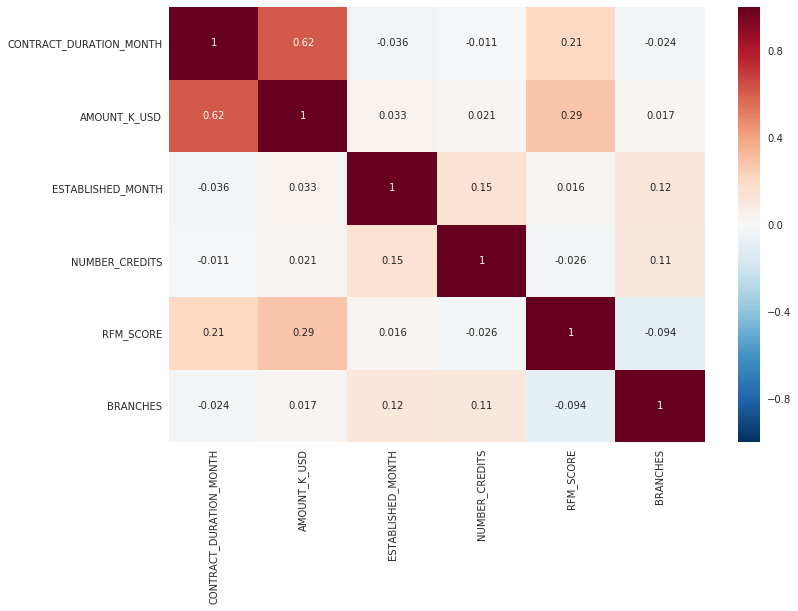

In [10]:
plt.figure(figsize=(12, 8))

corr_df = cust_pd.iloc[:,1:].corr()

sns.heatmap(corr_df, 
            xticklabels = corr_df.columns.values,
            yticklabels = corr_df.columns.values,
            annot = True);


* There is no strong correlation between most variables.
* The correlation between AMOUNT_K_USD and CONTRACT_DURATION_MONTH is moderate.

## Modeling And Evaluation

### Sklearn Random Forest

In [11]:
# convert IS_DEFAULT to 1/0
le = LabelEncoder()

cust_pd.loc[:,'IS_DEFAULT']= le.fit_transform(cust_pd.loc[:,'IS_DEFAULT'])

y = np.float32(cust_pd.IS_DEFAULT)

# drop y and merchant
X = cust_pd.drop(['IS_DEFAULT', 'MERCHANT'], axis = 1)


In [12]:
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper(
    [('ACCT_STATUS_K_USD', LabelEncoder()),
     ('CONTRACT_DURATION_MONTH', None),
     ('HISTORY',LabelEncoder()),
     ('CREDIT_PROGRAM', LabelEncoder()),
     ('AMOUNT_K_USD',None),
     ('ACCOUNT_TYPE',LabelEncoder()),
     ('ACCT_AGE',LabelEncoder()),
     ('STATE',LabelEncoder()),
     ('PRESENT_RESIDENT',LabelEncoder()),
     ('ESTABLISHED_MONTH',None),
     ('NUMBER_CREDITS',None)]
)

In [13]:
# split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
import sklearn.pipeline
from sklearn.preprocessing import OneHotEncoder

random_forest = RandomForestClassifier()
steps = [('mapper', mapper),('RandonForestClassifier', random_forest)]
pipeline = sklearn.pipeline.Pipeline(steps)
model=pipeline.fit( X_train, y_train )
model

Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('ACCT_STATUS_K_USD', LabelEncoder()), ('CONTRACT_DURATION_MONTH', None), ('HISTORY', LabelEncoder()), ('CREDIT_PROGRAM', LabelEncoder()), ('AMOUNT_K_USD', None), ('ACCOUNT_TYPE', LabelEncoder()), ('ACCT_AGE', LabelEnco...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [15]:
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = pipeline.predict( X_test )
### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )
### and print the report
print(report)

             precision    recall  f1-score   support

        0.0       0.75      0.87      0.81       140
        1.0       0.51      0.32      0.39        60

avg / total       0.68      0.70      0.68       200



### Save model to ML Repository

In [16]:
#convert the y_test array into a pandas dataframe
y_test_df = pd.DataFrame(y_test,columns=['IS_DEFAULT'])

In [17]:
from dsx_ml.ml import save

model_name = "CreditCard_Default_Model"
save(model = model, name = model_name, x_test=X_test, y_test=y_test_df, algorithm_type = 'Classification')

Using TensorFlow backend.


{'path': '/user-home/1006/DSX_Projects/DSX_Demos_Test/models/CreditCard_Default_Model/1',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python27/scikit-learn-0.19/DSX_Demos_Test/CreditCard_Default_Model/1'}

### Test Saved Model with Test UI
1. Save the notebook and switch to the **Models** tab of the project (**hint**: right click the project name link, DSX_Local_Workshop, at the top, and open with another tab in your browser). 
2. Under **Models**, find and click into your saved model. 
3. Click the **Test** link to test the model. 
4. When you enter values for String variabes, **don't** include quotes. 

You can use the following data for testing (please note that the order of fields may be different in the UI):<br/>
`ACCT_STATUS_K_USD='0 to 200 USD', HISTORY='CRITICAL ACCOUNT', CREDIT_PROGRAM='NEW CAR', ACCOUNT_TYPE='UNKNOWN/NONE', ACCT_AGE='4 to 7 YRS', STATE='NY', PRESENT_RESIDENT='2 to 3 YRS', CONTRACT_DURATION_MONTH=3, AMOUNT_K_USD=10000, ESTABLISHED_MONTH=40, NUMBER_CREDITS=2`

The results of the test is displayed as follows:<br/>
<img style="float: left;" src="https://github.com/elenalowery/DSX_Local_Workshop/blob/master/img/CC_Test.JPG?raw=true" alt="Test API" width=900 />

### Test the model with REST API (Optional)
This step demonstrates an "internal REST API" call to test the model (for an unpublished model). Notice that we are using DSX variables for the model endpoint and token. See documentation for external REST call syntax. An exernal REST call will have a different end point and will require authentication. 

In [18]:
json_payload =[{
    "MERCHANT":999,
    "ACCT_STATUS_K_USD":"0 USD",
    "CONTRACT_DURATION_MONTH":12,
    "HISTORY":"CRITICAL ACCOUNT",
    "CREDIT_PROGRAM":"NEW CAR",
    "AMOUNT_K_USD":2171,
    "ACCOUNT_TYPE":"up to 100 K USD",
    "ACCT_AGE":"1 to 4 YRS",
    "STATE":"NY",
    "IS_URBAN":"NO",
    "IS_XBORDER":"NO",
    "SELF_REPORTED_ASMT":"NO",
    "CO_APPLICANT":"YES",
    "GUARANTOR":"NO",
    "PRESENT_RESIDENT":"4",
    "OWN_REAL_ESTATE":"NO",
    "PROP_UNKN":"NO",
    "ESTABLISHED_MONTH":38,
    "OTHER_INSTALL_PLAN":"NO",
    "RENT":"NO",
    "OWN_RESIDENCE":"YES",
    "NUMBER_CREDITS":2,
    "RFM_SCORE":2,
    "BRANCHES":1,
    "TELEPHONE":"YES",
    "SHIP_INTERNATIONAL":"NO"}]

**Action Required**: Change the *scoring_endpoint* to the value that's shown as the *scoring_endpoint* afer running Save to ML repository function, for example *'scoring_endpoint': 'https://dsxl-api.ibm-private-cloud.svc.cluster.local/v3/project/score/Python27/scikit-learn-0.19/DSX_Local_Workshop_el/CreditCard_Default_Model/1'*. 

In [20]:
import requests, json, os
from pprint import pprint

online_path = 'https://dsxl-api/v3/project/score/Python27/scikit-learn-0.19/DSX_Demos_Test/CreditCard_Default_Model/1'

header_online = {'Content-Type': 'application/json', 'Authorization':os.environ['DSX_TOKEN']}

response_scoring = requests.post(online_path, json=json_payload, headers=header_online)

response_dict = json.loads(response_scoring.content)

n = 1
for response in response_dict['object']['output']['predictions']:
    print("{}. {}".format(n,response))
    n+=1

1. 0


**The prediction of 1 means that the cusotmer is likely to default on the credit card, and 0 that they will not.**

Created by **Catherine Cao** and **Sidney Phoon**
<br/>
catherine.cao@ibm.com<br/>
yfphoon@us.ibm.com<br/>

Dec 29, 2017